In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [37]:
# Constants
k = 1.38e-23  
e = 1.602e-19  

# Diode equation
def diode_eq(U, I0, T):
    return I0 * (np.exp(U * e / (k * T)) - 1)

# equations to solve for I0 and T
def system_to_solve(vars, U_data, I_data):
    I0, T = vars
    # Predicted current using the diode equation
    I_predicted = diode_eq(U_data, I0, T)
    # error between observed and predicted current
    error = I_data - I_predicted
    # sum of squared errors and mean error
    return [np.sum(error**2), np.mean(error)]


In [41]:
 #Newton's method implementation
def newtons(f, x0, TolX=1e-6, MaxIter=100, U_data=None, I_data=None):
    h = 1e-4  
    TolFun = np.finfo(float).eps  
    x0 = np.array(x0)  
    fx = np.array(f(x0, U_data, I_data)) 
    Nf = len(fx)  
    Nx = len(x0) 
    
    xx = [x0]  
    fx0 = np.linalg.norm(fx) 
    
    for k in range(MaxIter):
        # Jacobian matrix
        J = jacob(f, xx[-1], h, U_data, I_data)
        
        # Solve for dx
        dx = np.linalg.solve(J, -fx)
        
        # Damping to avoid divergence
        for l in range(3):
            dx = dx / 2  
            new_x = xx[-1] + dx  
            new_fx = np.array(f(new_x, U_data, I_data))  
            fxn = np.linalg.norm(new_fx)
            
            if fxn < fx0: 
                xx.append(new_x)
                fx = new_fx
                break
        
        # Check for convergence
        if fxn < TolFun or np.linalg.norm(dx) < TolX:
            break
        
        fx0 = fxn  
    
    return xx[-1], fx, xx  

# Numerical Jacobian calculation
def jacob(f, x, h=1e-4, U_data=None, I_data=None):
    N = len(x)
    J = np.zeros((N, N)) 
    I = np.eye(N)  
    x = np.array(x) 
    
    for n in range(N):
        
        # Central difference approximation for the Jacobian
        J[:, n] = (np.array(f(x + I[n] * h, U_data, I_data)) - np.array(f(x - I[n] * h, U_data, I_data))) / (2 * h)
    
    return J


In [39]:
 #Data
U_data = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])  # Voltage (V)
I_data = np.array([0.2e-4, 0.8e-4, 1.8e-4, 3.5e-4, 6.0e-4, 8.5e-4, 10.0e-4])  # Current (A)

# Initial guess for I0 and T
initial_guess = [1e-4, 500] 

#Newton's method
solution_newton, final_fx, history = newtons(system_to_solve, initial_guess, 1e-6, 100, U_data, I_data)
I0_newton, T_newton = solution_newton

print(f"Newton's Method Estimated I0: {I0_newton:.2e} A")
print(f"Newton's Method Estimated T: {T_newton:.2f} K")

#  fsolve method
solution_fsolve = fsolve(system_to_solve, initial_guess, args=(U_data, I_data))
I0_fsolve, T_fsolve = solution_fsolve

print(f"fsolve Estimated I0: {I0_fsolve:.2e} A")
print(f"fsolve Estimated T: {T_fsolve:.2f} K")


Newton's Method Estimated I0: 6.87e-05 A
Newton's Method Estimated T: 555.08 K
fsolve Estimated I0: 1.66e-04 A
fsolve Estimated T: 816.33 K


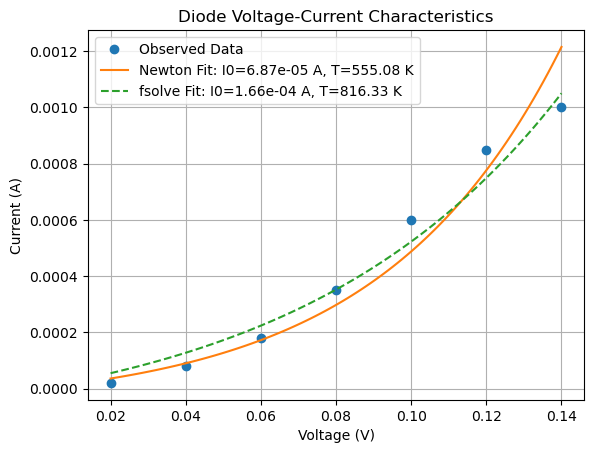

In [40]:
# Plotting the results
U_fine = np.linspace(min(U_data), max(U_data), 100)
I_predicted_newton = diode_eq(U_fine, I0_newton, T_newton) 
I_predicted_fsolve = diode_eq(U_fine, I0_fsolve, T_fsolve)  

# original data points and fitted curves
plt.plot(U_data, I_data, 'o', label='Observed Data')  
plt.plot(U_fine, I_predicted_newton, '-', label=f'Newton Fit: I0={I0_newton:.2e} A, T={T_newton:.2f} K')  
plt.plot(U_fine, I_predicted_fsolve, '--', label=f'fsolve Fit: I0={I0_fsolve:.2e} A, T={T_fsolve:.2f} K')  
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('Diode Voltage-Current Characteristics')
plt.legend()
plt.grid(True)
plt.show()